### Predicting Future Stock Market Trends

In [2]:
pip install yfinance # To read stocks from Yahoo

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install finta

Note: you may need to restart the kernel to use updated packages.


In [1]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, accuracy_score, ConfusionMatrixDisplay

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import Ridge, Lasso
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import Pipeline, make_pipeline
import category_encoders as ce
from sklearn.compose import make_column_transformer, TransformedTargetRegressor

In [8]:
days = 100000 # number of historical data days
interv = '1d' # rate
stock= 'MSFT' # symbol of stock

# list of symbols for technical indicators
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

[*********************100%***********************]  1 of 1 completed
9238


<AxesSubplot:xlabel='Date'>

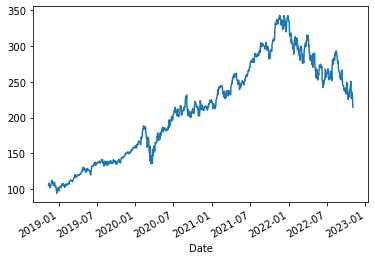

In [9]:
"""
Next we pull the historical data using yfinance
Rename the column names because finta uses the lowercase names
"""

start = (datetime.date.today() - datetime.timedelta( days ) )
end = datetime.datetime.today()

data = yf.download(stock, start=start, end=end, interval=interv)
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
print(len(data))

tmp = data.iloc[-1000:]
tmp['close'].plot()

### Feature Engineering 
Prepare features for modelings with proper encoding and transformations

ewm() function is used to provide exponential weighted functions.

<AxesSubplot:xlabel='Date'>

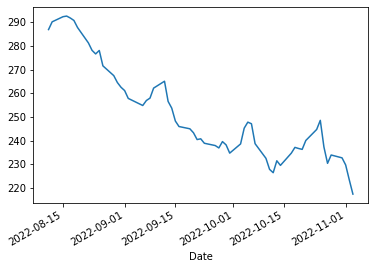

In [10]:
def exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are less 'rigid'
    :param alpha: weight factor to weight recent values more
    """
    
    return data.ewm(alpha=alpha).mean()

data = exponential_smooth(data, 0.65) # Specify smoothing factor α directly, 0<α≤1

tmp1 = data.iloc[-60:]
tmp1['close'].plot()


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9238 entries, 1986-03-13 to 2022-11-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       9238 non-null   float64
 1   high       9238 non-null   float64
 2   low        9238 non-null   float64
 3   close      9238 non-null   float64
 4   Adj Close  9238 non-null   float64
 5   volume     9238 non-null   float64
dtypes: float64(6)
memory usage: 505.2 KB


In [12]:
data.describe()

,open,high,low,close,Adj Close,volume
count,9238.000000,9238.000000,9238.000000,9238.000000,9238.000000,9.238000e+03
mean,45.051968,45.535926,44.552652,45.058769,39.884505,5.829692e+07
std,65.793219,66.466278,65.068022,65.796013,66.063861,3.408526e+07
min,0.088542,0.092938,0.088542,0.091653,0.057487,3.300712e+06
25%,4.977447,5.041457,4.937719,4.996431,3.133880,3.592927e+07
50%,26.947511,27.235721,26.708467,26.980873,19.051444,5.314757e+07
75%,41.871975,42.337554,41.380220,41.942156,30.834524,7.215886e+07
max,343.366656,347.694342,340.394154,342.163400,339.916048,1.031789e+09


'close' is right-skewed, since the mean value is larger than its median value (50th percentile)

Most of the data is actually skewed to the right

<AxesSubplot:xlabel='close', ylabel='Count'>

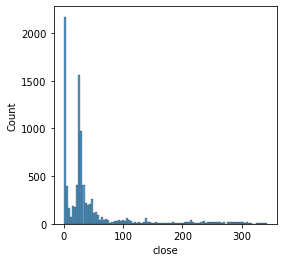

In [13]:
plt.figure(figsize=(4,4))
sns.histplot(data['close'])

We get a visual view of the outliers to the right

### Address Outliers

In [14]:
# function that checks the percentage of outliers based on the z-score

def detect_outliers_zscore(data, col):
    zscore = np.abs(stats.zscore(data[col]))
    outlier_list = np.where(zscore>4.5,True,False)
    
    return 100.*outlier_list.sum()/data.shape[0]

In [15]:
# calculate percentage of outliers using the detect_outliers_zscore() function
outlier_zscore_dic = {}
for col in ['close']:
    outlier_val = detect_outliers_zscore(data.dropna(subset=col), col)
    if outlier_val > 0:
        outlier_zscore_dic[col] = outlier_val


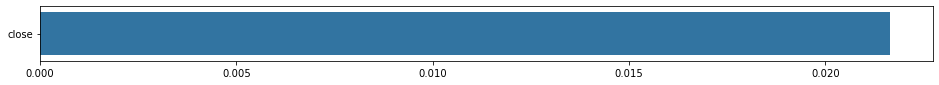

In [16]:
# sort the columns by their percentage of outliers
outlier_zscore_dic_sorted = {}
sorted_keys = sorted(outlier_zscore_dic, key=outlier_zscore_dic.get, reverse=True)

for w in sorted_keys:
    outlier_zscore_dic_sorted[w] = outlier_zscore_dic[w]
    
# plot percentage of outliers
plt.figure(figsize=(16, 1))
sns.barplot(x=list(outlier_zscore_dic_sorted.values()), y=list(outlier_zscore_dic_sorted.keys()));

#### Drop Outliers

In [17]:
for col, _ in outlier_zscore_dic.items():
    zscore = np.abs(stats.zscore(data[col]))
    
    size_before = data.shape[0]
    data.drop(data[np.abs(stats.zscore(data[col]))>4.5].index, inplace=True)
    size_after = data.shape[0]
    
    print('Cleaned {:.2f}% percentage of {}.'.format((size_before-size_after)*100./size_before, col))

Cleaned 0.02% percentage of close.


In [18]:
data.shape

(9236, 6)

<AxesSubplot:xlabel='close', ylabel='Count'>

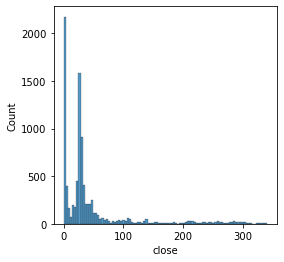

In [19]:
# Replot figure to see the change
plt.figure(figsize=(4,4))
sns.histplot(data['close'])

In [20]:
data = data.dropna() # remove any NaN values
data.tail()

,open,high,low,close,Adj Close,volume
Date,,,,,,
2022-10-28,228.529277,236.615316,227.052522,233.978308,233.978308,4.353257e+07
2022-10-31,231.929243,235.513359,229.715879,232.776911,232.776911,3.366864e+07
2022-11-01,233.665239,235.660679,228.165059,229.782418,229.782418,3.166902e+07
2022-11-02,230.931838,232.826240,222.883766,223.488850,223.488850,3.604871e+07
2022-11-03,223.884641,224.755686,217.096315,217.483598,217.483598,3.642908e+07


### Simple Model

Use Logistic Regression to build a basic model 

In [21]:
y=data['close'].astype(int)
features = [x for x in data.columns if x not in ['close']]
X = data[features]

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.2)

In [22]:
preprocessor = Pipeline(
    steps=[
        ('scaler', StandardScaler())
    ])


In [23]:
# build pipeline
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('log_reg', LogisticRegression(random_state=4, n_jobs=-1))
    ]
)
pipe.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', StandardScaler())])),
                ('log_reg', LogisticRegression(n_jobs=-1, random_state=4))])

### Score the Model

Evaluate accuracy

In [24]:
# predict
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

In [25]:
lr_accuracy=accuracy_score(y_train, y_train_pred)
lr_test_accuracy=accuracy_score(y_test, y_test_pred)

print('Logistic Regression Train Accuracy = '+str(lr_accuracy))
print('Logistic Regression Test Accuracy = '+str(lr_test_accuracy))

Logistic Regression Train Accuracy = 0.19707634001082838
Logistic Regression Test Accuracy = 0.1851400730816078


This is very low, we will create some confusion matrices

### Random Forest Classifier

In [26]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train) # fit model
rf_prediction=rf.predict(X_test) # predict
rf_accuracy= accuracy_score(y_test.values, rf_prediction)
print('RF Accuracy = '+str(rf_accuracy))

RF Accuracy = 0.8247394776018405


In [27]:
len(data)

9236

### KNN Classifier 

In [28]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train) # fit model
knn_prediction=knn.predict(X_test) # predict
knn_accuracy= accuracy_score(y_test.values, knn_prediction)
print(' Accuracy = '+str(knn_accuracy))

 Accuracy = 0.09026931925835702


### Another Model
Steps:
1. Set up a pipeline using the Pipeline object from sklearn.pipeline

Pipelines are used to automate a machine learning workflow. The pipeline can involve pre-processing, feature selection, classification/ regression and post-processing.

2. Perform a grid search for the best parameters using GridSearchCV()

Optimization tunes the model for the best performance. The success of any learning model rests on the selection of the best parameters that give the best possible results. 

3. Analyze the results and visualize

Scaler: For pre-processing data, i.e., transform the data to zero mean and unit variance using the StandardScaler().

In [29]:
scaler=StandardScaler()
transformer = TransformedTargetRegressor(regressor = Ridge())
pipe1= Pipeline([('scaler', StandardScaler()), ('ridge', Ridge())])

pipe1.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge())])

In [30]:
print('Training set score: ' + str(pipe1.score(X_train,y_train)))
print('Test set score: ' + str(pipe1.score(X_test,y_test)))

Training set score: 0.9999075445887593
Test set score: 0.9999116106944692


In [33]:
param_dict = {'ridge__alpha': [0.001, 0.1, 1.0, 10.0, 100.0, 1000.0]}
ridge=Ridge()
grid1 = GridSearchCV(pipe1, param_grid=param_dict)
grid1.fit(X_train, y_train)

train_preds=grid1.predict(X_train)
test_preds= grid1.predict(X_test)
model_1_train_mse = mean_squared_error(y_train, train_preds)
model_1_test_mse = mean_squared_error(y_test, test_preds)
model_1_best_alpha = grid1.best_params_

print(f'Test MSE: {model_1_test_mse}')
print(f'Best Alpha: {list(model_1_best_alpha.values())[0]}')
print('Training set score: ' + str(grid1.score(X_train, y_train)))
print('Test set score: ' + str(grid1.score(X_test, y_test)))
print(f"R2: {r2_score(y_test, test_preds)*100:.4}%")


Test MSE: 0.21098532111095497
Best Alpha: 0.001
Training set score: 0.9999509222922162
Test set score: 0.9999501290091789
R2: 100.0%


Text(0, 0.5, 'Predicted Stock at Closing')

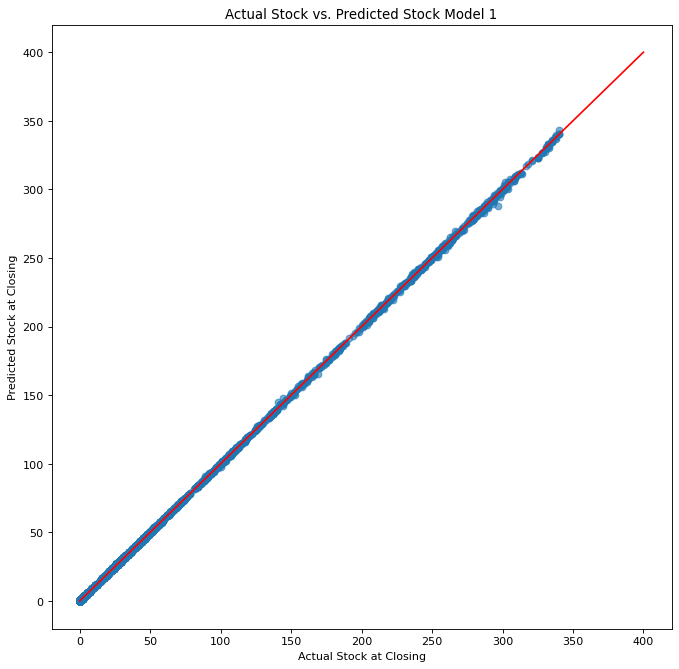

In [34]:
plt.figure(figsize = (10,10), dpi =80)
plt.scatter(x=y_test, y=test_preds, alpha=0.6)
plt.plot([0, 400], [0, 400], 'r-')
plt.title("Actual Stock vs. Predicted Stock Model 1")
plt.xlabel("Actual Stock at Closing")
plt.ylabel("Predicted Stock at Closing")

Training score: how the model is fitted in the training data. 

Test score: The higher the score, the better the model is generalized. 

Very low training score and low test score is under-fitting. Which is expected here as we only use year and odometer to fit the data. This model was just generated for practice and representation.

As we can see from the graph it fits very well.

### Time Series Decomposition

In [35]:
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import lag_plot


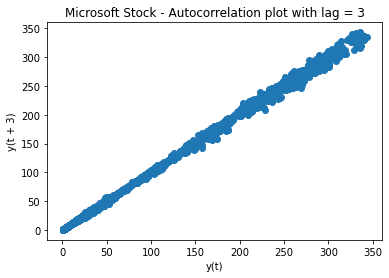

In [37]:
plt.figure()
lag_plot(data['open'], lag=3)
plt.title('Microsoft Stock - Autocorrelation plot with lag = 3')
plt.show()

In [42]:
train_data, test_data = data[0:int(len(df)*0.7)], df[int(len(df)*0.7):]
training_data = train_data['close'].values
test_data = test_data['close'].values
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))

C:\Users\mohar\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Testing Mean Squared Error is 2.865122016353166


Summary of the ARIMA code
We split the training dataset into train and test sets and we use the train set to fit the model, and generate a prediction for each element on the test set.

A rolling forecasting procedure is required given the dependence on observations in prior time steps for differencing and the AR model. To this end, we re-create the ARIMA model after each new observation is received.

Finally, we manually keep track of all observations in a list called history that is seeded with the training data and to which new observations are appended at each iteration.

Testing Mean Squared Error is 2.865

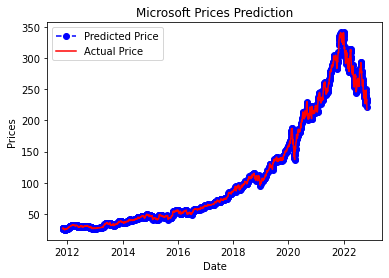

In [41]:
test_set_range = data[int(len(df)*0.7):].index
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.title('Microsoft Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()